# Identify Unusual Wallet Activity for Potential Fraud Detection

In [1]:
#import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

In [2]:
#Load the dataset
df = pd.read_csv("3_wallet_data.csv")
df.head(5)

,adv_id,transaction_type,value,currency,source_entity_type,created_at
0,d016c006-f927-48bc-987d-40a2f3f4648b,DEBIT,1.01,rupiyo_token,OFFER_REWARD,2024-10-21 15:48:09.797749+00:00
1,d016c006-f927-48bc-987d-40a2f3f4648b,DEBIT,0.02,rupiyo_token,DAILY_CHECKIN,2024-10-21 15:48:22.378338+00:00
2,d016c006-f927-48bc-987d-40a2f3f4648b,DEBIT,0.05,rupiyo_token,DAILY_CHECKIN,2024-10-22 02:52:52.695171+00:00
3,d016c006-f927-48bc-987d-40a2f3f4648b,DEBIT,0.10,rupiyo_token,DAILY_CHECKIN,2024-10-23 03:08:36.180386+00:00
4,ed359404-3d8a-4f3e-9d4e-38e6ef575254,DEBIT,1.01,rupiyo_token,OFFER_REWARD,2024-10-21 15:48:09.797749+00:00


In [3]:
#Clean dataset
df = df.dropna(subset=["adv_id", "value"])
df["value"] = df["value"].abs()

In [4]:
#Filter for Debit Transaction
df_debit = df[df["transaction_type"] == "DEBIT"]

In [5]:
# Aggregate User-Level Wallet Activity
agg = df_debit.groupby("adv_id")["value"].agg(
    count_debit="count",
    sum_debit="sum",
    mean_debit="mean",
    std_debit="std"
).reset_index()

### Creates user-level metrics like:

In [6]:
# Handle Missing Standard Deviation
agg["std_debit"] = agg["std_debit"].fillna(0)

In [7]:
# Calculate Z-Scores for Outlier Detection

for col in ["count_debit", "sum_debit", "mean_debit", "std_debit"]:
    agg[f"z_{col}"] = zscore(agg[col])

# Flag anomalies
agg["anomaly"] = agg[[f"z_{c}" for c in ["count_debit", "sum_debit", "mean_debit", "std_debit"]]].abs().max(axis=1) > 3

In [8]:
# Show top anomalies
anomalies = agg[agg["anomaly"]].sort_values(by="z_sum_debit", ascending=False)
anomalies.head(5)

,adv_id,count_debit,sum_debit,mean_debit,std_debit,z_count_debit,z_sum_debit,z_mean_debit,z_std_debit,anomaly
128521,f0ff29f5-7e7c-42d2-9984-b07918c19dbf,121,1139664.11,9418.711653,6302.018512,9.181284,44.190273,30.395628,22.138292,True
58691,6da00477-3c1a-455e-8ddb-aec86ece2e36,121,1139664.11,9418.711653,6302.018512,9.181284,44.190273,30.395628,22.138292,True
81926,995f8e7e-3e77-4adc-8d58-c30f1eb93114,121,1139664.11,9418.711653,6302.018512,9.181284,44.190273,30.395628,22.138292,True
109702,cdad6d5b-b60e-46a4-87c6-e676400761f9,121,1139664.11,9418.711653,6302.018512,9.181284,44.190273,30.395628,22.138292,True
129733,f33a8cc7-f459-4243-b797-a691d9137ab4,121,1139664.11,9418.711653,6302.018512,9.181284,44.190273,30.395628,22.138292,True


## Conclusion

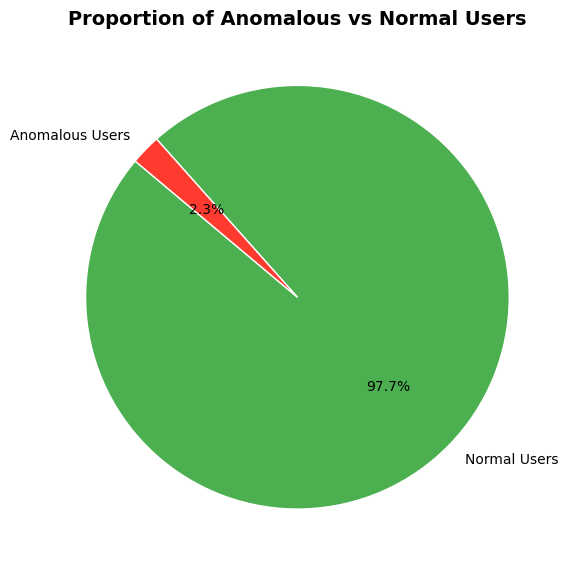

In [9]:
# Count anomaly vs normal users
counts = agg["anomaly"].value_counts()
labels = ["Normal Users", "Anomalous Users"]
colors = ["#4CAF50", "#FF3B30"]

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    colors=colors,
    startangle=140,
    wedgeprops={'edgecolor': 'white'}
)
plt.title("Proportion of Anomalous vs Normal Users", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()